In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline

In [4]:
# Define some arbitrary probability distribution
N = (m.e-1)**2 * (1 + 8*m.pi**2) / m.e**2 / (1 + 16*m.pi**2)
def p_2d(x1_,x2_):
    if x1_ > 1. or x1_ < 0. or x2_ > 1. or x2_ < 0.:
        return 0
    return m.cos(2*m.pi*x1_)**2 *m.exp(-x1_-x2_)/N

def p_unnorm(x):
    if np.all(x > 0) and np.all(x < 1):
        return m.exp(-np.sum(x)/len(x)) * np.cos(2*m.pi*np.sum(x))**2 
    else:
        return 0

In [5]:
# Rejection sampling
def generate_data_2d(n):
    out = np.zeros((n,2))
    counter = 0
    while (counter < n):
        x = r.random()
        y = r.random()
        if (p_2d(x,y)*N > 1):
            print(p_2d(x,y)*N)   
        if (r.random() < p_2d(x,y)*N):
            out[counter][0] = x
            out[counter][1] = y
            counter += 1
    return out

def generate_data_nd(n, d):
    out = np.zeros((n, d))
    counter = 0
    while (counter < n):
        x = np.random.rand(d)
        if (r.random() < p_unnorm(x)):
            out[counter] = x
            counter += 1
    return out

In [6]:
data_size = int(1e6)
dim = 2
x = generate_data_2d(data_size)

In [7]:
num_layers = 5
base_dist = BoxUniform(torch.zeros(dim), torch.ones(dim))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=dim))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=dim, 
        hidden_features=100,
        num_bins=15,
        num_blocks=3,
        fast_direction='forward'
    ))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [8]:
n_epochs = 25
batch_size = 1000
n_batches = m.ceil(data_size/batch_size)

x_torch = torch.tensor(x, dtype=torch.float32)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_torch.size()[0])    

    # Loop over batches
    cum_loss = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, data_size-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_torch[indices]
        
        # Take a step
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x).mean()
        loss.backward()
        optimizer.step()

        # Compute cumulative loss
        cum_loss = (cum_loss*batch + loss.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss = ", cum_loss)

epoch =  0 batch =  1 / 1000 loss =  0.607208788394928
epoch =  0 batch =  2 / 1000 loss =  0.49745677411556244
epoch =  0 batch =  3 / 1000 loss =  0.39216214915116626
epoch =  0 batch =  4 / 1000 loss =  0.31750514172017574
epoch =  0 batch =  5 / 1000 loss =  0.2565933972597122
epoch =  0 batch =  6 / 1000 loss =  0.21211042643214265
epoch =  0 batch =  7 / 1000 loss =  0.16828557862234966
epoch =  0 batch =  8 / 1000 loss =  0.13531209726352245
epoch =  0 batch =  9 / 1000 loss =  0.1087457166156835
epoch =  0 batch =  10 / 1000 loss =  0.08528615171089768
epoch =  0 batch =  11 / 1000 loss =  0.05972420297224413
epoch =  0 batch =  12 / 1000 loss =  0.04157652030698955
epoch =  0 batch =  13 / 1000 loss =  0.023527437176268835
epoch =  0 batch =  14 / 1000 loss =  0.007508751071457352
epoch =  0 batch =  15 / 1000 loss =  -0.009178371665378411
epoch =  0 batch =  16 / 1000 loss =  -0.024351665226276964
epoch =  0 batch =  17 / 1000 loss =  -0.03759088887668708
epoch =  0 batch =  

KeyboardInterrupt: 

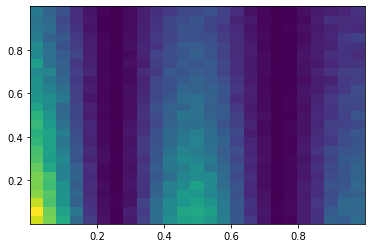

In [9]:
plt.hist2d(x[:,0], x[:,1], bins=25)
plt.show()

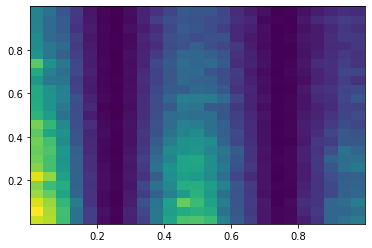

In [10]:
x_flow = flow.sample(data_size).detach().numpy()
plt.hist2d(x_flow[:,0], x_flow[:,1], bins=25)
plt.show()

In [11]:
log_probs_flow = flow.log_prob(x_flow).detach().numpy()

In [12]:
for i in range(10):
    print(m.log(p_2d(x_flow[i,0], x_flow[i,1])), log_probs_flow[i])

0.5487520405613039 0.56175435
1.3024179314062259 1.3112373
0.33909511341781784 0.34873614
0.9378620654558064 0.9883957
-1.2705910031112215 -1.0668238
0.007626264738432773 -0.08667948
0.7090158557288797 0.8068118
0.3360162350006469 0.4424536
0.9270543851507671 0.77649176
-1.850743576767979 -1.8869934
